In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds


# ¿Porqué ponemos esta linea? https://github.com/tensorflow/datasets/issues/3918
setattr(tfds.image_classification.cats_vs_dogs, '_URL', "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# Verificar que la URL se ha modificado correctamente
print(tfds.image_classification.cats_vs_dogs._URL)

# Descargar el set de datos de perros y gatos
datos, metadatos = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)


/Users/far/Desktop/Final Sprint/004-dshubapps/apps/04_dogs_and_cats/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


In [ ]:
# El código arrojaba error de recursividad al cargar el dataset. 
# Solución: Utilizar entorno virtual
# Python 3.11.0
# Tensorflow 2.15.0
# Tensorflow Datasets 4.9.4 

In [ ]:
# Mostramos los metadatos del dataset
metadatos

In [ ]:
# Dependencias para mostrar imagenes del dataset
# pip install pandas
# pip install Jinja2
# pip install pillow
# pip install matplotlib

In [ ]:
# Una forma de mostrar 5 ejemplos del set
tfds.as_dataframe(datos['train'].take(5), metadatos)

In [ ]:
# Otra forma de mostrar ejemplos del set
tfds.show_examples(datos['train'], metadatos)

In [ ]:
# Librerias para modificar imagenes
# pip install opencv-python

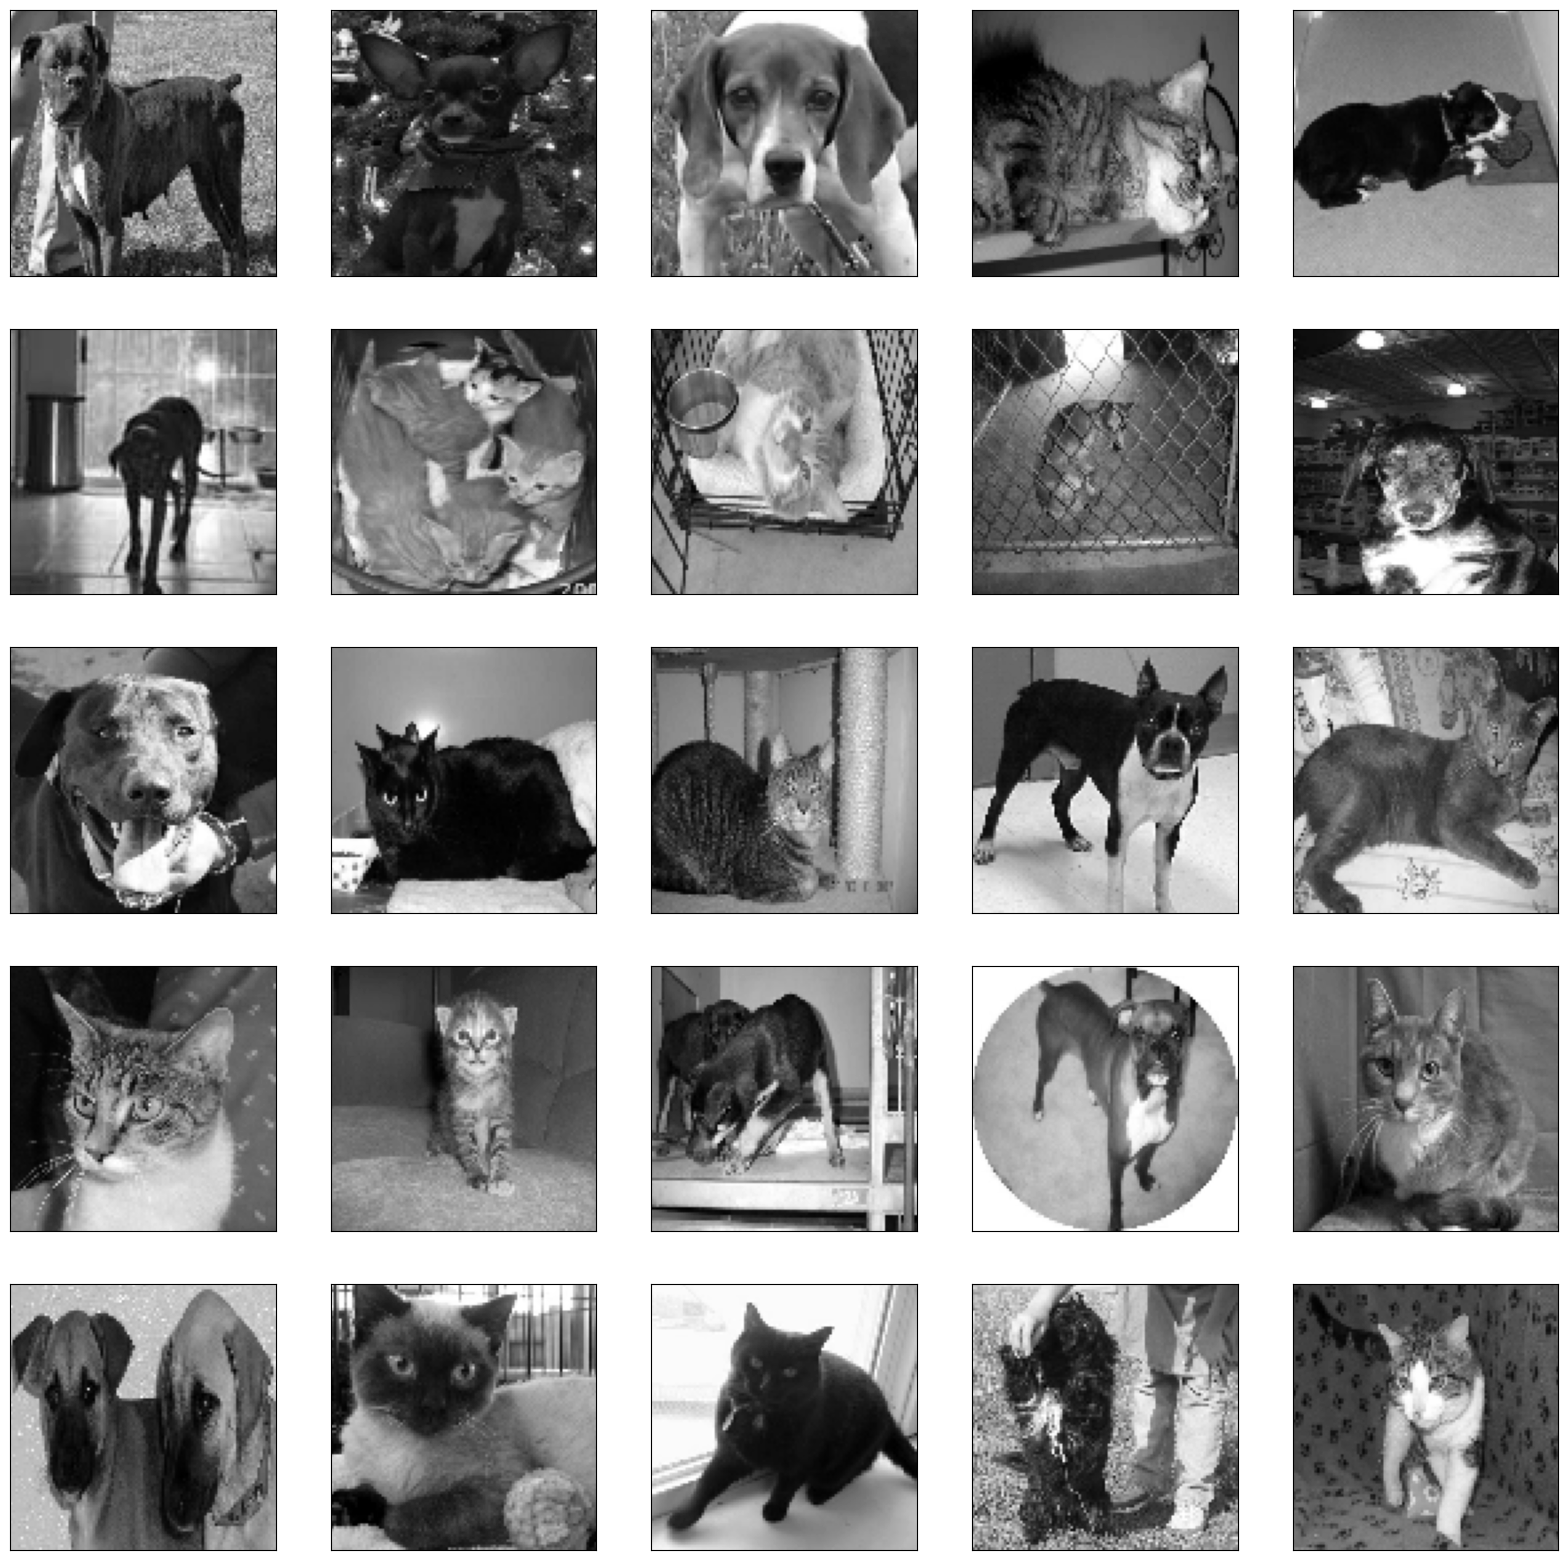

In [5]:
# Manipular y visualizar el set
# Lo pasamos a TAMANO_IMG (100x100) y a blanco y negro (solo para visualizar)
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(20,20))

TAMANO_IMG=100

for i, (imagen, etiqueta) in enumerate(datos['train'].take(25)):
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(imagen, cmap='gray')

In [6]:
#Variable que contendra todos los pares de los datos (imagen y etiqueta) ya modificados (blanco y negro, 100x100)
datos_entrenamiento = []

for i, (imagen, etiqueta) in enumerate(datos['train']): #Todos los datos
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  imagen = imagen.reshape(TAMANO_IMG, TAMANO_IMG, 1) #Cambiar tamano a 100,100,1
  datos_entrenamiento.append([imagen, etiqueta])

In [ ]:
#Ver los datos del primer indice
datos_entrenamiento[0]

In [ ]:
#Ver cuantos datos tengo en la variable
len(datos_entrenamiento)

In [7]:
#Preparar mis variables X (entradas) y y (etiquetas) separadas

X = [] #imagenes de entrada (pixeles)
y = [] #etiquetas (perro o gato)

for imagen, etiqueta in datos_entrenamiento:
  X.append(imagen)
  y.append(etiqueta)

In [8]:
X
#Normalizar los datos de las X (imagenes). Se pasan a numero flotante y dividen entre 255 para quedar de 0-1 en lugar de 0-255
import numpy as np

X = np.array(X).astype(float) / 255

In [9]:
y
#Convertir etiquetas en arreglo simple
y = np.array(y)

In [ ]:
X.shape

In [10]:
#Crear los modelos iniciales
#Usan sigmoid como salida (en lugar de softmax) para mostrar como podria funcionar con dicha funcion de activacion.
#Sigmoid regresa siempre datos entre 0 y 1. Realizamos el entrenamiento para al final considerar que si la respuesta se
#acerca a 0, es un gato, y si se acerca a 1, es un perro.

modeloDenso = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(250, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
#Compilar modelos. Usar crossentropy binario ya que tenemos solo 2 opciones (perro o gato)
modeloDenso.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN2.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
#La variable de tensorboard se envia en el arreglo de "callbacks" (hay otros tipos de callbacks soportados)
#En este caso guarda datos en la carpeta indicada en cada epoca, de manera que despues
#Tensorboard los lee para hacer graficas
tensorboardDenso = TensorBoard(log_dir='logs/denso')
modeloDenso.fit(X, y, batch_size=32,
                validation_split=0.15,
                epochs=100,
                callbacks=[tensorboardDenso])

In [ ]:
# pip install tensorboard tensorboardX

# Ejecutando el siguiente comando en terminal generamos un server con tensorboard y los datos del entrenamiento
# tensorboard --logdir=logs/denso


# Estado actual:
- Dataset cargado.
- Muestreo de datos de ejemplo graficados.
- Creación del modelo "Denso" 
- Entrenamiento del modelo "Denso"
- Visualización de los datos de entrenamiento del modelo "Denso"

In [ ]:
# Entrenamiento de Red Convolucional
# Rebajamos el numero de epoch para que no tarde mucho
tensorboardCNN = TensorBoard(log_dir='logs/cnn')
modeloCNN.fit(X, y, batch_size=32,
                validation_split=0.15,
                epochs=20,
                callbacks=[tensorboardCNN])